# Perfilado de Empleados con Clustering (Employee Profiling with Clustering)

Este notebook analiza datos de empleados para identificar perfiles mediante un modelo de K-Means, utilizando variables ampliadas y reducción de dimensionalidad con PCA. El análisis incluye:
- Carga de datos desde SQL Server
- Preprocesamiento de datos con escalamiento y PCA
- Determinación del número óptimo de clusters con el método del codo
- Entrenamiento del modelo K-Means
- Evaluación de resultados con métrica de calidad
- Visualización de clusters y centroides
- Almacenamiento de predicciones y métricas en SQL Server

## 1. Importación de Bibliotecas

Importamos las bibliotecas necesarias para el análisis, clustering y PCA.

In [1]:
import pandas as pd
import pymssql
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import logging

# Configuración de logging
logging.basicConfig(level=logging.INFO)

## 2. Conexión a Base de Datos y Consulta

Configuramos la conexión a SQL Server y ejecutamos la consulta para obtener los datos de empleados.

In [2]:
# Configuración de SQL Server
SQL_SERVER = "172.28.192.1:50121\\SQLEXPRESS"
SQL_DB = "HR_Analytics"
SQL_USER = "sa"
SQL_PASSWORD = "123456"

# Conectar a SQL Server usando pymssql
server_name = SQL_SERVER.split('\\')[0]
conn = pymssql.connect(
    server=server_name,
    user=SQL_USER,
    password=SQL_PASSWORD,
    database=SQL_DB
)

query = """
SELECT w.employee_id, w.department, w.first_name, w.last_name, w.gender, w.age, w.job_role, w.location, w.salary, w.hire_date, w.termination_date, w.onleave_date, w.performance_score, w.shift_type,
       ROUND(AVG(k.hours_worked),2) as avg_hours_worked, 
       ROUND(AVG(k.overtime_hours),2) as avg_overtime_hours, 
       ROUND(AVG(s.satisfaction_score),2) as avg_satisfaction_score,
       w.status as status,
       CASE WHEN w.status = 'Terminated' THEN 1 ELSE 0 END AS turnover,
       tp.predicted_turnover as predicted_turnover,
       ROUND(tp.turnover_probability,2) as turnover_probability,
       CASE WHEN tp.turnover_probability >=0.70 AND tp.turnover_probability < 0.90 THEN 'Moderate'
            WHEN tp.turnover_probability >=0.90 THEN 'High'
            ELSE 'No Risk' END AS turnover_risk_level
FROM Workday_Employees w
LEFT JOIN Kronos_TimeEntries k ON w.employee_id = k.employee_id
LEFT JOIN Employee_Surveys s ON w.employee_id = s.employee_id
LEFT JOIN Turnover_Predictions tp ON w.employee_id = tp.employee_id
GROUP BY w.employee_id, w.department, w.salary, w.hire_date, w.status, tp.predicted_turnover, tp.turnover_probability, w.first_name, w.last_name, w.job_role, w.location, w.gender, w.age, w.termination_date, w.onleave_date, w.performance_score, w.shift_type
"""

df = pd.read_sql(query, conn)
logging.info(f"Datos cargados: {len(df)} registros")
df.head(10)

C:\Users\joey_\AppData\Local\Temp\ipykernel_5504\3373245533.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
INFO:root:Datos cargados: 1000 registros


,employee_id,department,first_name,last_name,gender,age,job_role,location,salary,hire_date,...,performance_score,shift_type,avg_hours_worked,avg_overtime_hours,avg_satisfaction_score,status,turnover,predicted_turnover,turnover_probability,turnover_risk_level
0,1847,HR,Audrey,Williams,Female,35,Analyst,Los Angeles,91976.17,2021-06-10,...,3,Afternoon,5.85,0.29,5.0,Active,0,0,0.00,No Risk
1,1023,IT,Tammy,Rogers,Female,27,Analyst,Chicago,70459.79,2017-07-11,...,3,Morning,5.63,0.34,5.0,Active,0,0,0.00,No Risk
2,1615,Marketing,Robert,Johnson,Male,20,Clerk,Los Angeles,40049.55,2024-08-14,...,8,Afternoon,5.70,0.36,3.0,Active,0,0,0.00,No Risk
3,1660,Inventory,David,Brown,Male,26,Associate,Miami,63957.78,2016-10-07,...,10,Night,5.65,0.43,2.0,Active,0,0,0.00,No Risk
4,1521,Sales,Timothy,Mills,Male,37,Associate,Miami,70665.66,2022-01-23,...,2,Morning,NaN,NaN,4.0,Terminated,1,1,0.99,High
5,1219,HR,Dawn,Hurley,Female,45,Analyst,Miami,87512.74,2019-01-06,...,9,Afternoon,5.81,0.32,4.0,Active,0,0,0.00,No Risk
6,1481,Sales,Thomas,Neal,Male,28,Clerk,New York,51368.67,2023-12-31,...,7,Morning,5.68,0.51,NaN,Active,0,0,0.01,No Risk
7,1535,Sales,William,Jackson,Male,29,Analyst,New York,87985.06,2019-11-07,...,9,Morning,NaN,NaN,3.0,On Leave,0,1,0.18,No Risk
8,1585,HR,David,Larsen,Male,31,Analyst,New York,70800.58,2015-09-11,...,10,Morning,NaN,NaN,NaN,Terminated,1,1,0.39,No Risk
9,1053,Sales,Stephen,Summers,Male,23,Clerk,New York,34273.28,2021-11-15,...,3,Afternoon,5.77,0.40,4.0,Terminated,1,1,0.90,Moderate


## 3. Preprocesamiento de Datos

Realizamos el preprocesamiento, escalamiento y reducción de dimensionalidad con PCA.

Columnas disponibles en df: ['employee_id', 'first_name', 'last_name', 'age', 'salary', 'hire_date', 'termination_date', 'onleave_date', 'performance_score', 'avg_hours_worked', 'avg_overtime_hours', 'avg_satisfaction_score', 'status', 'turnover', 'predicted_turnover', 'turnover_probability', 'tenure', 'department_HR', 'department_IT', 'department_Inventory', 'department_Marketing', 'department_Sales', 'gender_Male', 'job_role_Associate', 'job_role_Clerk', 'job_role_Manager', 'job_role_Supervisor', 'location_Houston', 'location_Los Angeles', 'location_Miami', 'location_New York', 'shift_type_Morning', 'shift_type_Night', 'turnover_risk_level_Moderate', 'turnover_risk_level_No Risk', 'cluster']
Columnas categóricas disponibles para codificación: []
No se encontraron columnas categóricas para codificar. Revisar la consulta SQL.
Variables seleccionadas para el modelo:
- salary
- tenure
- performance_score
- age
- avg_hours_worked
- avg_overtime_hours
- avg_satisfaction_score
- turnover_pr

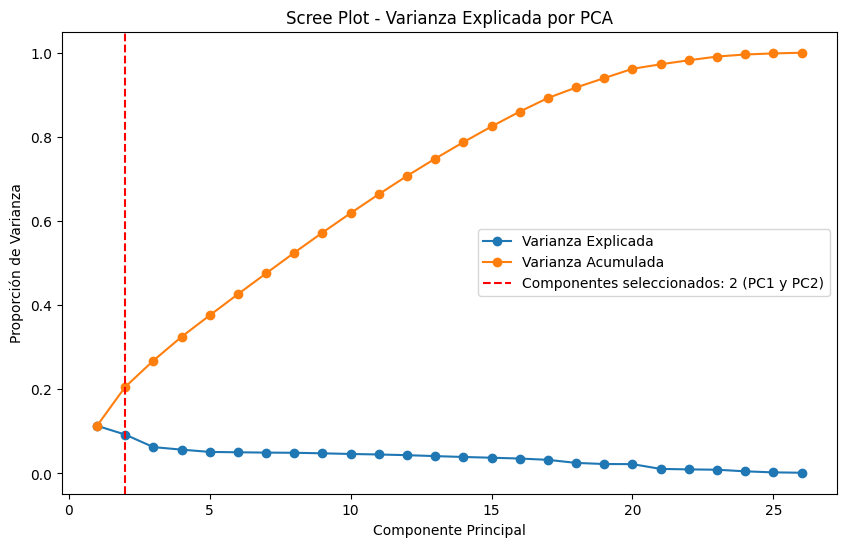

INFO:root:Datos preprocesados, escalados y transformados con PCA. Componentes seleccionados: 2 (PC1 y PC2)



Contribución de las variables a PC1 y PC2 (Loadings):
                                   PC1       PC2
salary                        0.953578  0.167188
tenure                       -0.041893 -0.008931
performance_score            -0.040628  0.332800
age                           0.889965  0.087509
avg_hours_worked              0.004376  0.002057
avg_overtime_hours            0.026152  0.020773
avg_satisfaction_score        0.055831  0.090710
turnover_probability          0.172011 -0.908145
department_HR                 0.022618  0.020306
department_IT                 0.005178  0.055094
department_Inventory          0.005537  0.014793
department_Marketing         -0.046815  0.069779
department_Sales              0.008686 -0.145709
gender_Male                   0.043623  0.068905
job_role_Associate           -0.325779 -0.067015
job_role_Clerk               -0.646048 -0.063924
job_role_Manager              0.735554  0.204889
job_role_Supervisor           0.267560 -0.090384
location_Houst

In [10]:
# Convertir hire_date a años de antigüedad (tenure)
df['hire_date'] = pd.to_datetime(df['hire_date'])
df['tenure'] = (datetime.datetime.now() - df['hire_date']).dt.days / 365.25

# Manejo de valores nulos
df['avg_hours_worked'] = df['avg_hours_worked'].fillna(df['avg_hours_worked'].mean())
df['avg_overtime_hours'] = df['avg_overtime_hours'].fillna(df['avg_overtime_hours'].mean())
df['avg_satisfaction_score'] = df['avg_satisfaction_score'].fillna(df['avg_satisfaction_score'].mean())
df['turnover_probability'] = df['turnover_probability'].fillna(df['turnover_probability'].mean())

# Depuración: Verificar columnas disponibles en el DataFrame
print("Columnas disponibles en df:", df.columns.tolist())

# Definir columnas categóricas esperadas
expected_categorical_columns = ['department', 'gender', 'job_role', 'location', 'shift_type', 'turnover_risk_level']

# Filtrar solo las columnas categóricas que existen en el DataFrame
available_categorical_columns = [col for col in expected_categorical_columns if col in df.columns]
print("Columnas categóricas disponibles para codificación:", available_categorical_columns)

# Codificación de variables categóricas solo para las columnas disponibles
if available_categorical_columns:
    df = pd.get_dummies(df, columns=available_categorical_columns, drop_first=True)
else:
    print("No se encontraron columnas categóricas para codificar. Revisar la consulta SQL.")

# Selección de características para clustering
features = ['salary', 'tenure', 'performance_score', 'age', 'avg_hours_worked', 
            'avg_overtime_hours', 'avg_satisfaction_score', 'turnover_probability'] + \
           [col for col in df.columns if any(prefix in col for prefix in ['department_', 'gender_', 'job_role_', 'location_', 'shift_type_', 'turnover_risk_level_'])]

# Listar las variables seleccionadas para el modelo
print("Variables seleccionadas para el modelo:")
for feature in features:
    print(f"- {feature}")

X = df[features]

# Estandarización de las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Seleccionar solo las dos primeras componentes principales (PC1 y PC2)
n_components = 2
X_pca = X_pca[:, :n_components]

# Mostrar resultados de PCA: Varianza explicada
pca_results = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Varianza Explicada': pca.explained_variance_ratio_,
    'Varianza Acumulada': np.cumsum(pca.explained_variance_ratio_)
})
print("\nResultados de PCA - Varianza Explicada:")
print(pca_results[['Componente', 'Varianza Explicada', 'Varianza Acumulada']].to_string(index=False))

# Graficar la varianza explicada (scree plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', label='Varianza Explicada')
plt.plot(range(1, len(np.cumsum(pca.explained_variance_ratio_)) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', label='Varianza Acumulada')
plt.axvline(x=n_components, color='r', linestyle='--', label=f'Componentes seleccionados: {n_components} (PC1 y PC2)')
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza')
plt.title('Scree Plot - Varianza Explicada por PCA')
plt.legend()
plt.savefig('pca_scree_plot.png')
plt.show()

# Calcular las cargas (loadings) de PCA para identificar la contribución de las variables
loadings = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features
)

# Mostrar las cargas de PC1 y PC2
print("\nContribución de las variables a PC1 y PC2 (Loadings):")
print(loadings[['PC1', 'PC2']].to_string())

# Identificar las variables más influyentes por componente
print("\nVariables más influyentes por Componente Principal:")
for i in range(n_components):
    component = f'PC{i+1}'
    top_vars = loadings[component].abs().sort_values(ascending=False).head(3)
    print(f"\n{component}:")
    for var, value in top_vars.items():
        print(f"- {var}: {value:.3f}")

logging.info(f"Datos preprocesados, escalados y transformados con PCA. Componentes seleccionados: {n_components} (PC1 y PC2)")

## 4. Método del Codo para Determinar el Número Óptimo de Clusters

Utilizamos el método del codo para encontrar el número óptimo de clusters, evaluando desde 1 hasta 10 clusters, y renderizamos la gráfica en el notebook.

INFO:root:Número óptimo de clusters seleccionado: 8


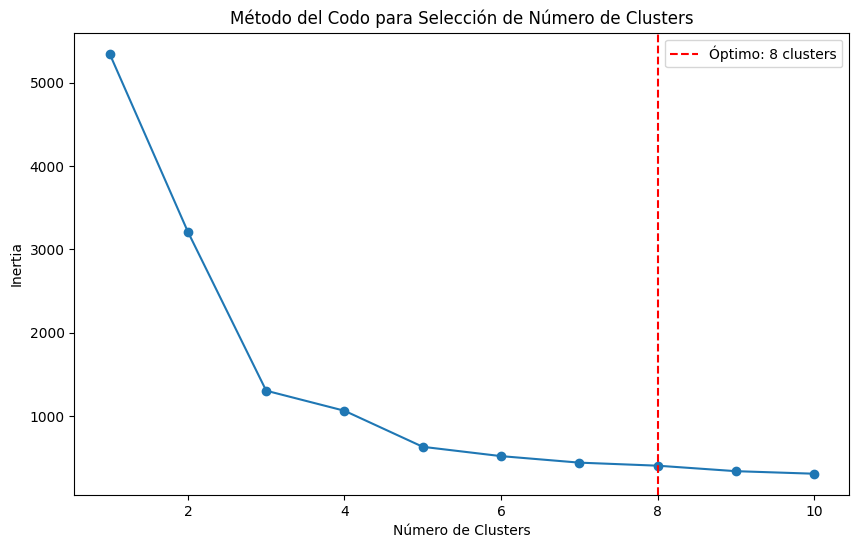

Métricas del método del codo guardadas en la base de datos.


In [11]:
# Método del codo
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))
        davies_bouldin_scores.append(davies_bouldin_score(X_pca, kmeans.labels_))
    else:
        silhouette_scores.append(0)
        davies_bouldin_scores.append(0)

# Determinar el número óptimo de clusters usando el método del codo
diff = np.diff(inertia)
diff_r = diff[1:] / diff[:-1]
optimal_k = k_range[np.argmax(diff_r) + 1]
logging.info(f"Número óptimo de clusters seleccionado: {optimal_k}")

# Visualización del método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.title('Método del Codo para Selección de Número de Clusters')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Óptimo: {optimal_k} clusters')
plt.legend()
plt.savefig('elbow_method.png')
plt.show()

# Guardar métricas del codo en la base de datos
elbow_data = pd.DataFrame({
    'num_clusters': k_range,
    'inertia': inertia,
    'silhouette_score': silhouette_scores,
    'davies_bouldin_score': davies_bouldin_scores,
    'selected': [1 if k == optimal_k else 0 for k in k_range]
})

cursor = conn.cursor()
cursor.execute("TRUNCATE TABLE Elbow_Method_Results")
for _, row in elbow_data.iterrows():
    cursor.execute(
        "INSERT INTO Elbow_Method_Results (num_clusters, inertia, silhouette_score, davies_bouldin_score, selected) VALUES (%s, %s, %s, %s, %s)",
        (row['num_clusters'], row['inertia'], row['silhouette_score'], row['davies_bouldin_score'], row['selected'])
    )
conn.commit()
print("Métricas del método del codo guardadas en la base de datos.")


## 5. Entrenamiento del Modelo K-Means

Entrenamos el modelo K-Means con el número óptimo de clusters y evaluamos su calidad.

INFO:root:Métricas del modelo: Silhouette Score=0.463, Davies-Bouldin Score=0.711, Mean Squared Distance=0.406, Quality=Aceptable


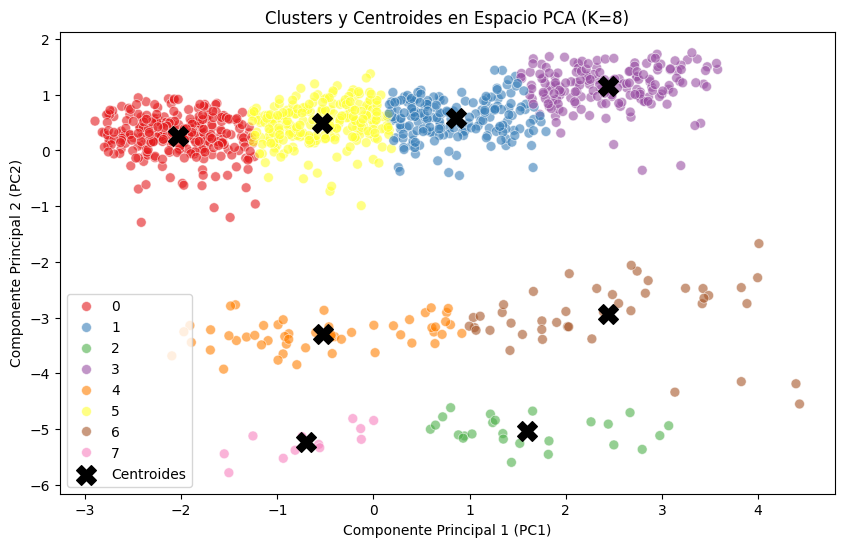

In [12]:
# Entrenar el modelo K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_pca)

# Asignar etiquetas de cluster a los datos
df['cluster'] = kmeans.labels_

# Calcular métricas del modelo
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
davies_bouldin_avg = davies_bouldin_score(X_pca, kmeans.labels_)
mean_squared_distance = kmeans.inertia_ / len(X_pca)

# Determinar la calidad del modelo
def determine_quality(silhouette, davies_bouldin):
    if silhouette >= 0.5 and davies_bouldin <= 1.0:
        return 'Bueno'
    elif silhouette >= 0.3 and davies_bouldin <= 1.5:
        return 'Aceptable'
    else:
        return 'Pobre'

quality = determine_quality(silhouette_avg, davies_bouldin_avg)

logging.info(f"Métricas del modelo: Silhouette Score={silhouette_avg:.3f}, Davies-Bouldin Score={davies_bouldin_avg:.3f}, Mean Squared Distance={mean_squared_distance:.3f}, Quality={quality}")

# Visualizar clusters y centroides en el espacio de PC1 y PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='Set1', s=50, alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X', label='Centroides')
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.title(f'Clusters y Centroides en Espacio PCA (K={optimal_k})')
plt.legend()
plt.savefig('cluster_pca_plot_section5.png')
plt.show()

## 6. Almacenamiento de Resultados

Guardamos las asignaciones de clusters y las métricas del modelo (incluyendo calidad) en SQL Server.

In [14]:
# Guardar asignaciones de clusters
cluster_results = df[['employee_id', 'cluster']]
cursor = conn.cursor()
cursor.execute("TRUNCATE TABLE Employee_Clusters")
for _, row in cluster_results.iterrows():
    # Convertir numpy.int64 a int estándar de Python
    employee_id = int(row['employee_id'])
    cluster = int(row['cluster'])
    cursor.execute(
        "INSERT INTO Employee_Clusters (employee_id, cluster) VALUES (%s, %s)",
        (employee_id, cluster)
    )

# Guardar métricas del modelo
run_datetime = datetime.datetime.now()
cursor.execute(
    "INSERT INTO Clustering_Metrics (run_datetime, num_clusters, silhouette_score, davies_bouldin_score, mean_squared_distance, quality) VALUES (%s, %s, %s, %s, %s, %s)",
    (run_datetime, optimal_k, silhouette_avg, davies_bouldin_avg, mean_squared_distance, quality)
)

conn.commit()
conn.close()
print("Resultados de clustering y métricas guardados en la base de datos.")

Resultados de clustering y métricas guardados en la base de datos.


## 7. Visualización de Resultados

Visualizamos las características promedio por cluster y los clusters con sus centroides en el espacio de PCA.

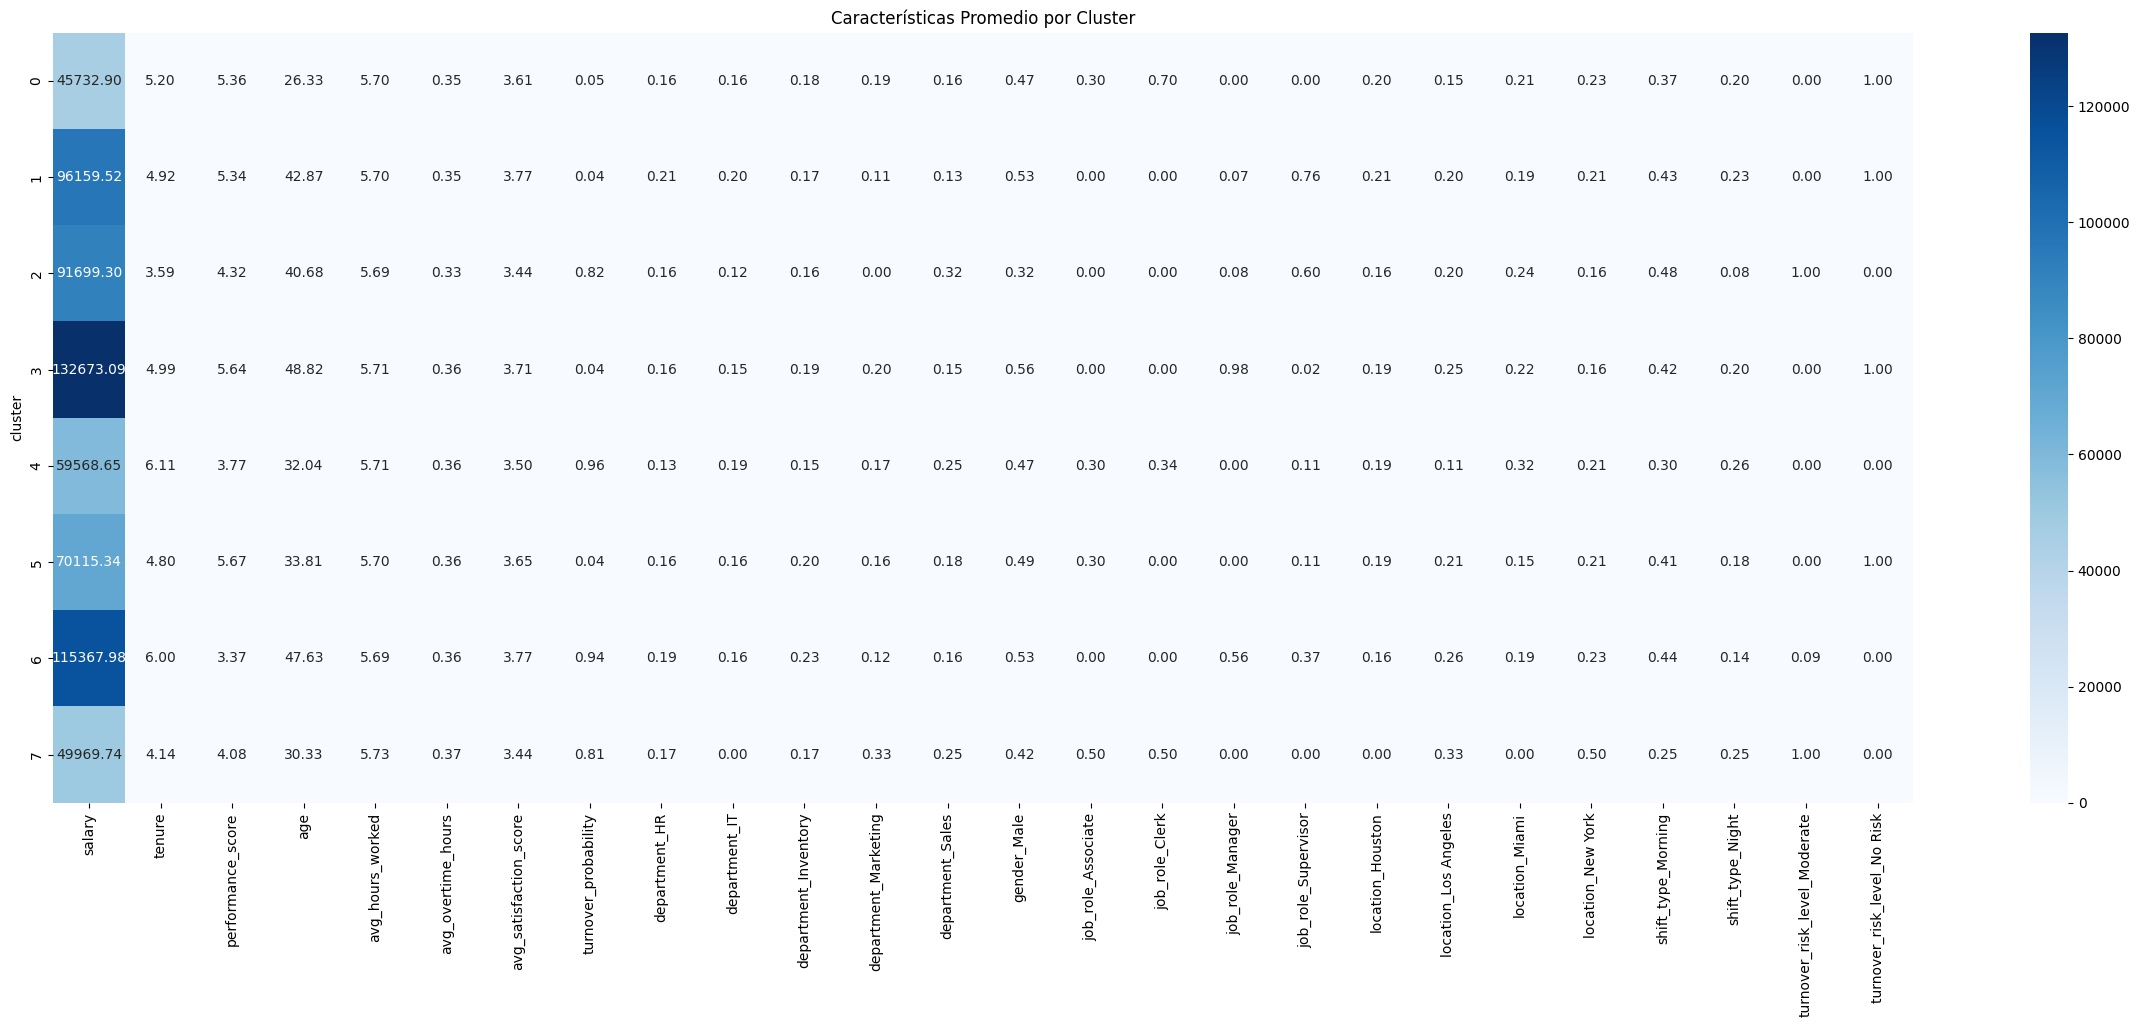

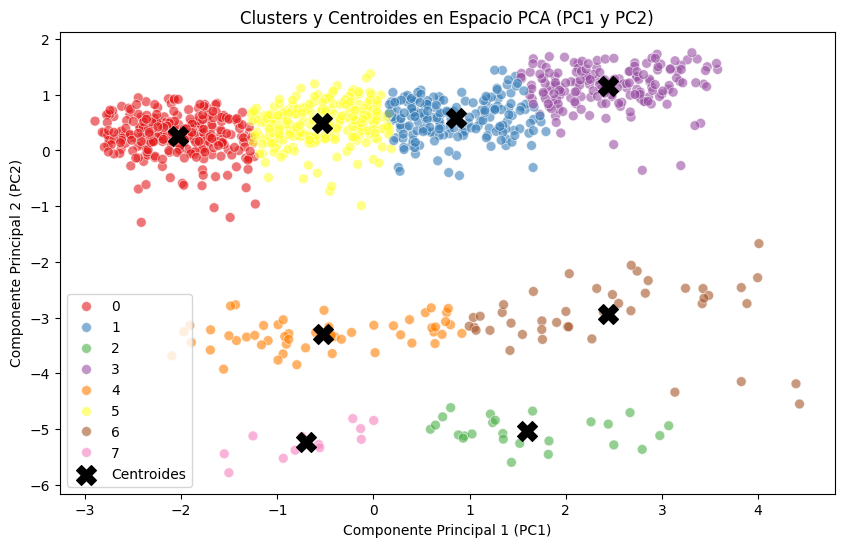

<Figure size 1200x1000 with 0 Axes>

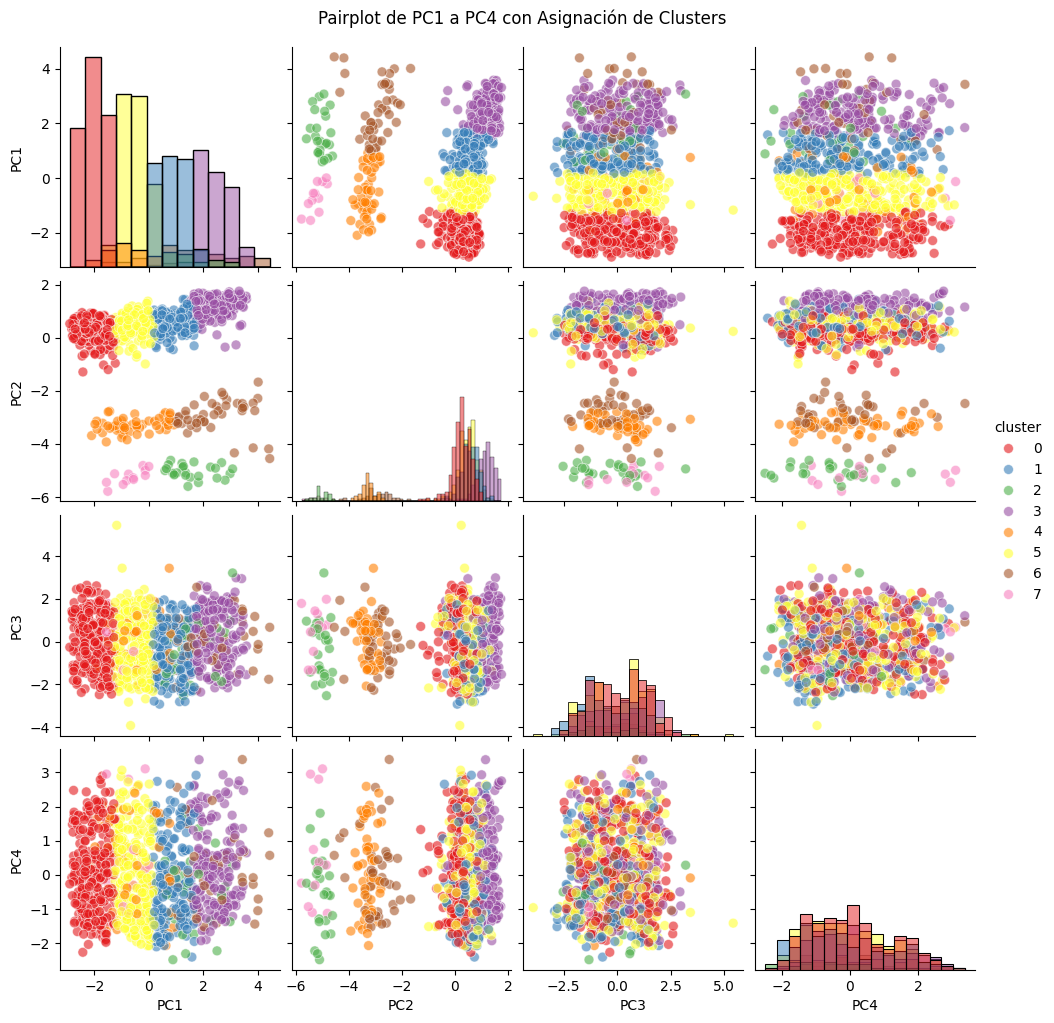

INFO:root:Visualización de perfiles de clusters, gráfico PCA y pairplot generados.


In [18]:
# Calcular estadísticas por cluster
cluster_summary = df.groupby('cluster')[features].mean()

# Visualizar estadísticas
plt.figure(figsize=(30, 10))
sns.heatmap(cluster_summary, annot=True, cmap='Blues', fmt='.2f')
plt.title('Características Promedio por Cluster')
plt.savefig('cluster_summary.png')
plt.show()

# Visualizar clusters y centroides en el espacio de PC1 y PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='Set1', s=50, alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X', label='Centroides')
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.title('Clusters y Centroides en Espacio PCA (PC1 y PC2)')
plt.legend()
plt.savefig('cluster_pca_plot.png')
plt.show()

# Preparar datos para pairplot con PC1 a PC4
# Asegurarse de que X_pca tenga al menos 4 componentes (PCA original calcula todos, tomamos los primeros 4)
X_pca_extended = pca.transform(X_scaled)[:, :4]  # Tomar PC1, PC2, PC3, PC4
pca_df = pd.DataFrame(X_pca_extended, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['cluster'] = df['cluster']

# Generar pairplot para PC1 a PC4
plt.figure(figsize=(12, 10))
sns.pairplot(pca_df, hue='cluster', palette='Set1', diag_kind='hist', plot_kws={'alpha': 0.6, 's': 50})
plt.suptitle('Pairplot de PC1 a PC4 con Asignación de Clusters', y=1.02)
plt.savefig('pairplot_pca_1to4.png')
plt.show()

logging.info("Visualización de perfiles de clusters, gráfico PCA y pairplot generados.")
